## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os
from sklearn.metrics import accuracy_score

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [3]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

In [4]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [5]:
len(fmnist_dataset_test)

10000

In [6]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [7]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 200),
            nn.BatchNorm1d(200, momentum = None),
            nn.Dropout(p=0.3),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.BatchNorm1d(100, momentum = 0.2),
            nn.Dropout(p=0.3),
            nn.Linear(100, num_classes),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [8]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 200]         157,000
       BatchNorm1d-3                  [-1, 200]             400
           Dropout-4                  [-1, 200]               0
              ReLU-5                  [-1, 200]               0
            Linear-6                  [-1, 100]          20,100
       BatchNorm1d-7                  [-1, 100]             200
           Dropout-8                  [-1, 100]               0
            Linear-9                   [-1, 10]           1,010
       LogSoftmax-10                   [-1, 10]               0
Total params: 178,710
Trainable params: 178,710
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.68
Estimated T

Your experiments come here:

In [9]:
model = TinyNeuralNetwork().to(device)
opt = torch.optim.SGD(model.parameters(), lr=1e-1, momentum=0.8)
loss_func =  nn.NLLLoss()

In [10]:
def train(model, opt, loss_func):
    model.train(True)
    for i in range(30):
        for x_batch, y_batch in train_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            opt.zero_grad()
            preds = model.forward(x_batch)
            loss = loss_func(preds, y_batch.long())
            loss.backward()
            opt.step()

In [11]:
train(model, opt, loss_func)

In [12]:
def accuracy(model, data_loader):
    for x_batch, y_batch in data_loader:
        probs = model.forward(x_batch).detach().numpy()
        argmax = np.argmax(probs, axis=1)
    return accuracy_score(argmax, y_batch.detach().numpy())

In [13]:
print(f'The accuracy of TinyNeuralNetwork is {accuracy(model, test_loader)}')

The accuracy of TinyNeuralNetwork is 0.9375


### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [13]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 300),
            nn.ReLU(),
            nn.Linear(300, 400),
            nn.ReLU(),
            nn.Linear(400, 300),
            nn.ReLU(),
            nn.Linear(300, 200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, num_classes),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [14]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 300]         235,500
              ReLU-3                  [-1, 300]               0
            Linear-4                  [-1, 400]         120,400
              ReLU-5                  [-1, 400]               0
            Linear-6                  [-1, 300]         120,300
              ReLU-7                  [-1, 300]               0
            Linear-8                  [-1, 200]          60,200
              ReLU-9                  [-1, 200]               0
           Linear-10                  [-1, 100]          20,100
             ReLU-11                  [-1, 100]               0
           Linear-12                  [-1, 100]          10,100
             ReLU-13                  [-1, 100]               0
           Linear-14                  [

In [15]:
model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.SGD(model.parameters(), lr=1e-1, momentum=0.8)
loss_func =  nn.NLLLoss()

n_overfit_epoch = 150

In [16]:
indices = torch.arange(5000)
train_5k = torch.utils.data.Subset(fmnist_dataset_train, indices)
train_loader_subset = torch.utils.data.DataLoader(train_5k, batch_size=128, shuffle=True, num_workers=2)

In [17]:
def train_save_loss_score(model, train_loader, test_loader, loss_fn, opt, n_epochs):
    train_loss = []
    train_accuracy = []
    test_loss = []
    test_accuracy = []
    
    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_train_accuracy = []
        ep_test_loss = []
        ep_test_accuracy = []
        model.train(True)        
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            opt.zero_grad()
            preds = model.forward(X_batch)
            loss = loss_func(preds, y_batch.long())
            loss.backward()
            opt.step()
            ep_train_loss.append(loss.item())
            ep_train_accuracy.append(accuracy_score(np.argmax(preds.detach().numpy(), axis=1), y_batch.detach().numpy()))
        model.train(False)
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                preds = model.forward(X_batch)                
                ep_test_loss.append(loss_func(preds, y_batch.long()).item())
                ep_test_accuracy.append(accuracy_score(np.argmax(preds, axis=1), y_batch.detach().numpy()))
        train_loss.append(np.mean(ep_train_loss))
        train_accuracy.append(np.mean(ep_train_accuracy))
        test_loss.append(np.mean(ep_test_loss))
        test_accuracy.append(np.mean(ep_test_accuracy))
    return train_loss, train_accuracy, test_loss, test_accuracy

In [18]:
train_loss, train_accuracy, test_loss, test_accuracy = train_save_loss_score(model, 
                                                                             train_loader_subset, 
                                                                             test_loader, 
                                                                             loss_func, 
                                                                             opt, 
                                                                             n_overfit_epoch)

In [19]:
def plot_data(train_data, test_data, title, ylabel):
    plt.figure(figsize=(12, 8))
    plt.title(title)
    plt.xlabel('epoch')
    plt.ylabel(ylabel)
    plt.plot(train_data, label='train data')
    plt.plot(test_data, label='test data')
    plt.legend()
    plt.show()

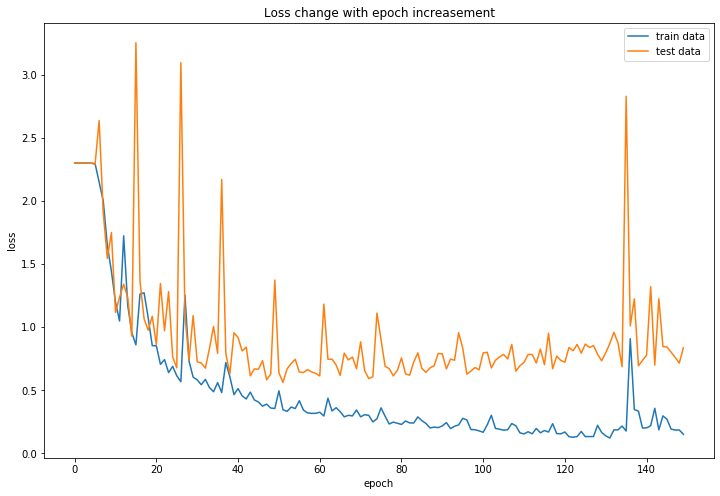

In [20]:
plot_data(train_loss, test_loss, 'Loss change with epoch increasement', 'loss')

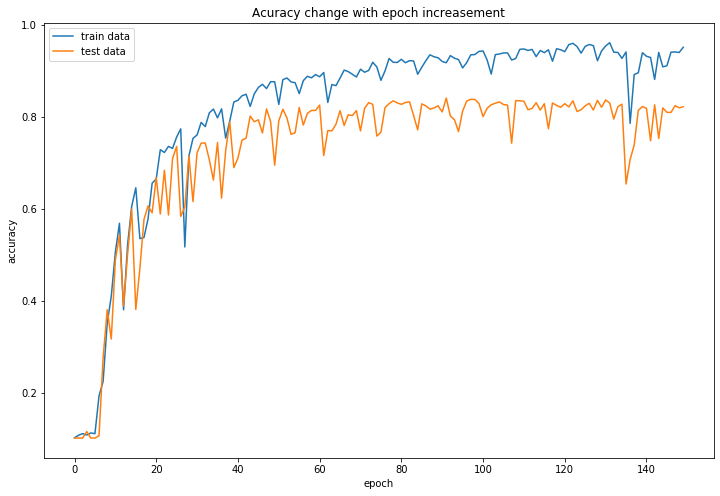

In [21]:
plot_data(train_accuracy, test_accuracy, 'Acuracy change with epoch increasement', 'accuracy')

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [22]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 300),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(300, 400),
            nn.Dropout(0.4),
            nn.ReLU(),
            nn.Linear(400, 300),
            nn.BatchNorm1d(300),
            nn.ReLU(),
            nn.Linear(300, 200),
            nn.BatchNorm1d(200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.Dropout(0.25),
            nn.ReLU(),
            nn.Linear(100, num_classes),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [23]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 300]         235,500
           Dropout-3                  [-1, 300]               0
              ReLU-4                  [-1, 300]               0
            Linear-5                  [-1, 400]         120,400
           Dropout-6                  [-1, 400]               0
              ReLU-7                  [-1, 400]               0
            Linear-8                  [-1, 300]         120,300
       BatchNorm1d-9                  [-1, 300]             600
             ReLU-10                  [-1, 300]               0
           Linear-11                  [-1, 200]          60,200
      BatchNorm1d-12                  [-1, 200]             400
             ReLU-13                  [-1, 200]               0
           Linear-14                  [

In [24]:
model = FixedNeuralNetwork().to(device)
opt = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
loss_func = nn.NLLLoss()

# Your experiments, come here
train_loss, train_accuracy, test_loss, test_accuracy = train_save_loss_score(model, 
                                                                             train_loader_subset, 
                                                                             test_loader, 
                                                                             loss_func, 
                                                                             opt, 
                                                                             n_overfit_epoch)

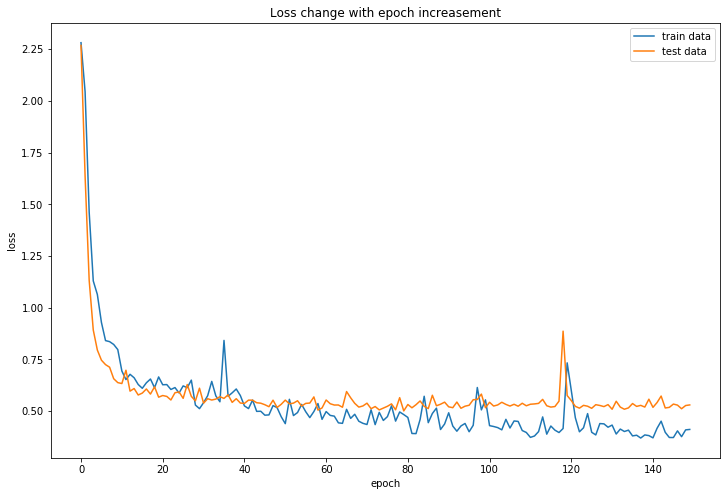

In [25]:
plot_data(train_loss, test_loss, 'Loss change with epoch increasement', 'loss')

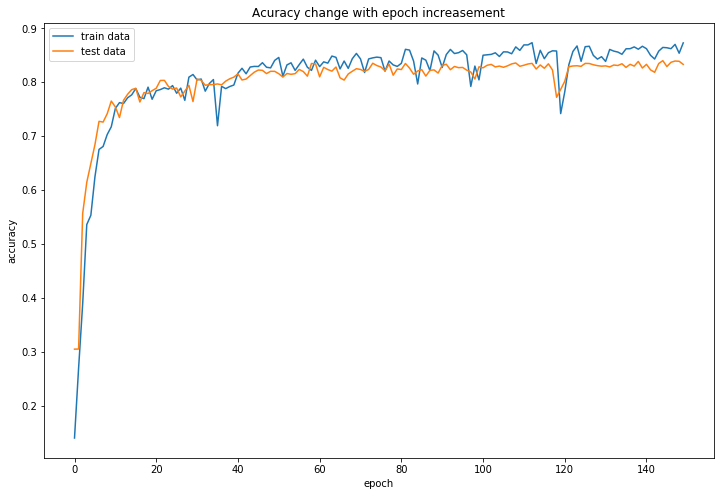

In [26]:
plot_data(train_accuracy, test_accuracy, 'Acuracy change with epoch increasement', 'accuracy')

### Conclusions:
It can be seen comparing plots for overfitted and fixed nets that dropout and batch normalization are efficient with overfitting problem even when the train set is very little.